# Heart Failure Analysis


## The story behind The Data

Cardiovascular diseases (CVDs) are the number 1 cause of death all over the world, taking an estimated **17.9** million lives each year, which accounts for 31% of all deaths worldwide.
Heart failure is a common event caused by CVDs and this dataset contains 12 features that can be used to predict mortality by heart failure, as well as analyze and understand the main factor for these diseases.

Most cardiovascular diseases can be prevented by addressing behavioural risk factors such as tobacco use, unhealthy diet and obesity, physical inactivity and harmful use of alcohol using population-wide strategies.

People with CV disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a great analysis of it can be of great help.

**A full ERD can be found [here](https://dbdiagram.io/d/638ce6b2bae3ed7c4544a01b)**

# Data Description
In this task, few datasets are provided:

1. **`base_metrics_patient.csv`** - the base DF which contains the main metrics measured per each patient, these are:
 
	- `uniqueID` - patient ID
	- `smoking` - If the patient smokes or not (boolean)
    - `ejection_fraction` - Percentage of blood leaving the heart at each contraction (%)
	- `serum_sodium` - Level of serum sodium in the blood (mEq/L)
	- `platelets` - Platelets in the blood (kiloplatelets/mL)
	- `creatinine_phosphokinase` - Level of the CPK enzyme in the blood (mcg/L)
	- `diabetes` - If the patient has diabetes (boolean)
	- `serum_creatinine` - Level of serum creatinine in the blood (mg/dL)
2. **`blood_metrics_df.csv`** - an additional dataset contains some more metrics about each patient. Specifically, it contains:
    - `uniqueID` - patient ID
    - `anaemia` - Decrease of red blood cells or hemoglobin (boolean)
    - `high_blood_pressure` - If the patient has hypertension (boolean)
3. **`demographic_data_health.csv`** - some extra data about the patient’s demographics, specifically:
    - `uniqueID` - patient ID
    - `age` - patient’s age
    - `sex` - (male - 1, female - 0)
4. **`follow_up_df.csv` -** a dataset contains details about a follow up check that was with that patient. It contains:
    - `uniqueID` - patient ID
    - `time` - time passed (in days) between the measurement date (see dataset #1) until that “follow up” date
    - `DEATH_EVENT` - If the patient deceased during the follow-up period (boolean)

# SQL Assessment
This notebook was used in an enviroment that allows for SQL database integration, which won't work in a standard jupyter notebook. Analysis follows in Python, as well as a link to Tableau visual

In [1]:


SELECT * from base_metrics_patient LIMIT 10

SyntaxError: invalid syntax (196078517.py, line 1)

 ### 1. How many death cases do we have in this dataset?

In [2]:

SELECT sum(death_event) from follow_up_df


 ### 2. Per each sex (M, F), show the amount of “death” records in the data

In [3]:

    SELECT dd.sex, sum(fud.death_event)
    FROM demographic_data as dd
    JOIN follow_up_df as fud
    ON dd.uniqueid = fud.uniqueid
    GROUP BY dd.sex

### Calculate the following statistics for serum_creatinine, per each anaemia category - min, max, average, range

In [4]:

SELECT bd.anaemia, min(bmp.serum_creatinine), max(bmp.serum_creatinine), avg(bmp.serum_creatinine), MAX(bmp.serum_creatinine) - MIN(bmp.serum_creatinine) AS range_serum_creatinine
FROM blood_metrics_df as bd
JOIN base_metrics_patient as bmp
ON bd.uniqueid = bmp.uniqueid
GROUP BY bd.anaemia

###  4. Let’s define a new metric - almost_outlier. An “almost_outlier” is a value which its serum_creatinine is higher than the overall serum_creatinine average, by 1.5. How many “almost_outlier” do we have in our dataset?**

In [5]:


SELECT COUNT(*)
FROM base_metrics_patient
WHERE serum_creatinine > (SELECT AVG(serum_creatinine) FROM base_metrics_patient) + 1.5;

### Per each gender + smoker category, find out the min, max and mean of creatinine_phosphokinase

In [6]:
-- Per each gender + smoker category, find out the min, max and mean of creatinine_phosphokinase
SELECT
    dd.sex,
    bmp.smoking,
    MIN(bmp.creatinine_phosphokinase) as min_creatinine_phosphokinase,
    MAX(bmp.creatinine_phosphokinase) as max_creatinine_phosphokinase,
    AVG(bmp.creatinine_phosphokinase) as mean_creatinine_phosphokinase
FROM demographic_data as dd
JOIN base_metrics_patient as bmp
ON dd.uniqueid = bmp.uniqueid
GROUP BY dd.sex, bmp.smoking;

In [7]:
-- create a table view of demographic_data that also adds age_group column
DROP VIEW IF EXISTS demographic_data_view;
CREATE VIEW demographic_data_view AS
SELECT uniqueid,
    age,
    sex,
    CASE
        WHEN age BETWEEN 10 AND 50 THEN '10 < x ≤ 50'
        WHEN age BETWEEN 50 AND 70 THEN '50 < x ≤ 70'
        WHEN age BETWEEN 70 AND 80 THEN '70 < x ≤ 80'
        WHEN age BETWEEN 80 AND 120 THEN '80 < x ≤ 120'
    END AS age_group
FROM demographic_data
        

Error: Please select an integration.

  ### Per each age_group, find out:
    
    - Out of persons in each group, what’s the % of smokers are there. Make sure to round the answer up to 4 decimal points
    - how many patients with high_blood_pressure out there
    - what is the avg. level of serum_sodium. Make sure to round the answer up to 4 decimal points

In [8]:
SELECT ddv.age_group,
 ROUND(SUM(bmp.smoking) /((SELECT COUNT (*) FROM base_metrics_patient) * 1.0000), 4) AS percent_smoker,
SUM(bmd.high_blood_pressure) AS high_blood_pressure_count,
ROUND(AVG(bmp.serum_sodium), 4) AS average_serum_sodium
FROM demographic_data_view AS ddv
JOIN base_metrics_patient AS bmp
ON ddv.uniqueid = bmp.uniqueid
JOIN blood_metrics_df as bmd
ON ddv.uniqueid = bmd.uniqueid
GROUP BY ddv.age_group


Error: Please select an integration.

### 7. Using the age_group column from above, some hospitals are interested to know who are the top 10 patient ID with the highest serum_creatinine. Help them find that information

In [9]:


SELECT  ddv.age_group, bmp.uniqueid, bmp.serum_creatinine
FROM base_metrics_patient as bmp
JOIN demographic_data_view as ddv
ON ddv.uniqueid = bmp.uniqueid

ORDER BY bmp.serum_creatinine DESC
LIMIT 10;

Error: Please select an integration.

### 8. Let’s create a new variable called “general_serum”, composed of a multiplication between serum_sodium and serum_creatinine, and divided by 100 (a_multiply_b / 100). Once created, per each smoking + diabetes level (boolean variable), some hospitals would like to know the patient IDs with the lowest level of that new metric. As such, please generate a table of smoking + diabetes, as well as the bottom 5 patient IDs, with the lowest level of “general_serum”

In [10]:
--First create a table view so we won't alter the original database, and we will ad a new column in it or general_serum
DROP VIEW IF EXISTS base_metrics_patient_view;
CREATE VIEW base_metrics_patient_view AS
SELECT uniqueid,
    smoking,
    ejection_fraction,
    serum_sodium,
    platelets,
    creatinine_phosphokinase,
    diabetes,
    serum_creatinine,
    (serum_sodium * serum_creatinine)/100 AS general_serum
FROM base_metrics_patient

In [11]:
SELECT smoking,
    diabetes,
    uniqueid,
    SUM(general_serum) AS general_serum
FROM base_metrics_patient_view
GROUP BY smoking, diabetes, uniqueid
ORDER BY general_serum ASC
LIMIT 5;

## Tableau tasks

See Link below for a Tableau dashboard on this dataset

[Tableau Dashboard](https://public.tableau.com/views/HeartFailureAnalysis_16742214184600/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link)
![image-8](image-8.png)

In this brief analysis, there are 2 key points I noticed that may have an impact on heart disease, is that for those patients that died in this dataset and were diabetic or smoker, the ejecction fraction was lower and the sodium levels were lower then the recommended 135-145.

In [2]:

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [120]:
# loading datasets and see their "head"
base_metrics_patient_df = pd.read_csv("base_metrics_patient.csv")
blood_metrics_df = pd.read_csv("blood_metrics_df.csv")
demographic_df = pd.read_csv("demographic_data_health.csv")
follow_up_df = pd.read_csv("follow_up_df.csv")

In [121]:
base_metrics_patient_df.head(3)


,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,uniqueID,diabetes,serum_creatinine
0,0,20,130,265000.00,582,0,0,1.9
1,0,38,136,263358.03,7861,1,0,1.1
2,1,20,129,162000.00,146,2,0,1.3


In [122]:
blood_metrics_df.head(3)

,unqiueID,anaemia,high_blood_pressure
0,0,0,1
1,1,0,0
2,2,0,0


In [123]:
demographic_df.head(3)

,uniqueID,age,sex
0,0,75.0,1
1,1,55.0,1
2,2,65.0,1


In [124]:
follow_up_df.head(3)

,uniqueID,time,DEATH_EVENT
0,0,4,1
1,1,6,1
2,2,7,1


In [125]:
# Let's see the head of base_metrics in a more visualized manner
base_metrics_patient_df.head().style.background_gradient(cmap='Reds').set_properties(**{'font-family': 'Segoe UI'}).hide_index()

smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,uniqueID,diabetes,serum_creatinine
0,20,130,265000.000000,582,0,0,1.900000
0,38,136,263358.030000,7861,1,0,1.100000
1,20,129,162000.000000,146,2,0,1.300000
0,20,137,210000.000000,111,3,0,1.900000
0,20,116,327000.000000,160,4,1,2.700000


In [126]:
# Descriptive statistics in a more visualized way
base_metrics_patient_df.describe().T.style.background_gradient(cmap = "Reds_r").set_properties(**{"font-family" : "Segoe UI"})

,count,mean,std,min,25%,50%,75%,max
smoking,299.000000,0.321070,0.467670,0.000000,0.000000,0.000000,1.000000,1.000000
ejection_fraction,299.000000,38.083612,11.834841,14.000000,30.000000,38.000000,45.000000,80.000000
serum_sodium,299.000000,136.625418,4.412477,113.000000,134.000000,137.000000,140.000000,148.000000
platelets,299.000000,263358.029264,97804.236869,25100.000000,212500.000000,262000.000000,303500.000000,850000.000000
creatinine_phosphokinase,299.000000,581.839465,970.287881,23.000000,116.500000,250.000000,582.000000,7861.000000
uniqueID,299.000000,149.000000,86.458082,0.000000,74.500000,149.000000,223.500000,298.000000
diabetes,299.000000,0.418060,0.494067,0.000000,0.000000,0.000000,1.000000,1.000000
serum_creatinine,299.000000,1.393880,1.034510,0.500000,0.900000,1.100000,1.400000,9.400000


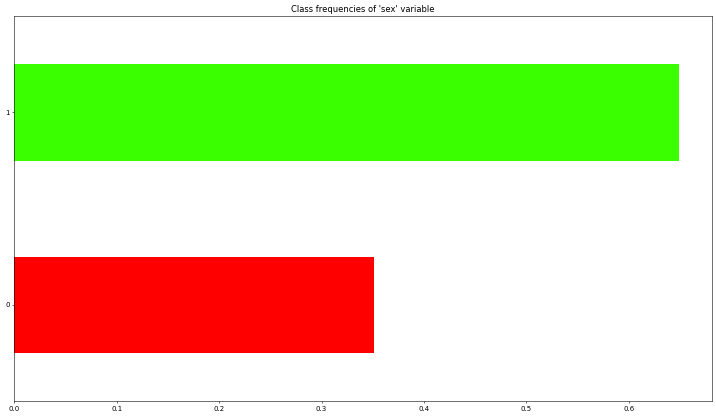

In [127]:
# Let's see the relationship between categoric variable "sex" and its frequency
plt.figure(figsize = (18, 10), dpi = 50, edgecolor = "black")

(demographic_df["sex"].value_counts(ascending = True, normalize = True)
 .plot.barh(color= ["#FF0000", "#3AFF00"])
 .set_title("Class frequencies of 'sex' variable"));

# Q: Why do we have values besides 1 / 0 ???

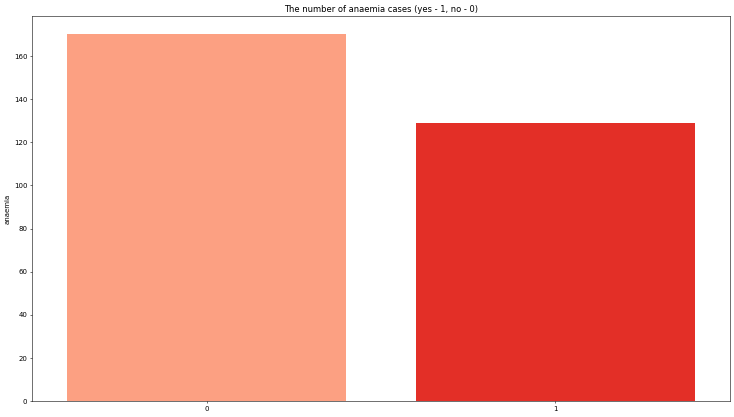

In [128]:
plt.figure(figsize = (18, 10), dpi = 50, edgecolor = "black")

sns.barplot(x = blood_metrics_df["anaemia"].value_counts().index,
            y = blood_metrics_df["anaemia"].value_counts(),
            data = blood_metrics_df, palette = "Reds",
            saturation = 1).set(title = "The number of anaemia cases (yes - 1, no - 0)");

# It can be seen from this graph that the presence of anemia is less than the absence
# Why do we have other values?

In [129]:
base_metrics_patient_df.describe()

,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,uniqueID,diabetes,serum_creatinine
count,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000
mean,0.32107,38.083612,136.625418,263358.029264,581.839465,149.000000,0.418060,1.39388
std,0.46767,11.834841,4.412477,97804.236869,970.287881,86.458082,0.494067,1.03451
min,0.00000,14.000000,113.000000,25100.000000,23.000000,0.000000,0.000000,0.50000
25%,0.00000,30.000000,134.000000,212500.000000,116.500000,74.500000,0.000000,0.90000
50%,0.00000,38.000000,137.000000,262000.000000,250.000000,149.000000,0.000000,1.10000
75%,1.00000,45.000000,140.000000,303500.000000,582.000000,223.500000,1.000000,1.40000
max,1.00000,80.000000,148.000000,850000.000000,7861.000000,298.000000,1.000000,9.40000


In [130]:
blood_metrics_df.describe()

,unqiueID,anaemia,high_blood_pressure
count,299.000000,299.000000,299.000000
mean,149.000000,0.431438,0.351171
std,86.458082,0.496107,0.478136
min,0.000000,0.000000,0.000000
25%,74.500000,0.000000,0.000000
50%,149.000000,0.000000,0.000000
75%,223.500000,1.000000,1.000000
max,298.000000,1.000000,1.000000


In [131]:
follow_up_df.describe()

,uniqueID,time,DEATH_EVENT
count,299.000000,299.000000,299.00000
mean,149.000000,130.260870,0.32107
std,86.458082,77.614208,0.46767
min,0.000000,4.000000,0.00000
25%,74.500000,73.000000,0.00000
50%,149.000000,115.000000,0.00000
75%,223.500000,203.000000,1.00000
max,298.000000,285.000000,1.00000


In [132]:
demographic_df.describe()

,uniqueID,age,sex
count,299.000000,299.000000,299.000000
mean,149.000000,60.833893,0.648829
std,86.458082,11.894809,0.478136
min,0.000000,40.000000,0.000000
25%,74.500000,51.000000,0.000000
50%,149.000000,60.000000,1.000000
75%,223.500000,70.000000,1.000000
max,298.000000,95.000000,1.000000


- In base_metrics_patient, the creatinine_phosphokinase levels seem very high for the max. Normal levels run from 10-120 mcg/l while the max in this dataset is at 7861
- Platelets looks to have an outlier above 800,000
- serum creatinine has a high number at its max.
- Ejection Fraction has outlier around 80

In [133]:
base_metrics_patient_df.loc[base_metrics_patient_df['creatinine_phosphokinase'] == 7861]

,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,uniqueID,diabetes,serum_creatinine
1,0,38,136,263358.03,7861,1,0,1.1


In [134]:
base_metrics_patient_df[base_metrics_patient_df['creatinine_phosphokinase'] > 1000].creatinine_phosphokinase.value_counts()

7861    1
2656    1
1211    1
1767    1
2281    1
1202    1
1021    1
2794    1
1185    1
2017    1
2522    1
1199    1
1051    1
2695    1
1688    1
1820    1
2060    1
1896    1
1419    1
3966    1
1808    1
1380    1
3964    1
7702    1
5882    1
5209    1
1876    1
1082    1
2442    1
4540    1
1548    1
1610    1
2261    1
1846    1
2334    1
2413    1
Name: creatinine_phosphokinase, dtype: int64

<AxesSubplot: ylabel='creatinine_phosphokinase'>

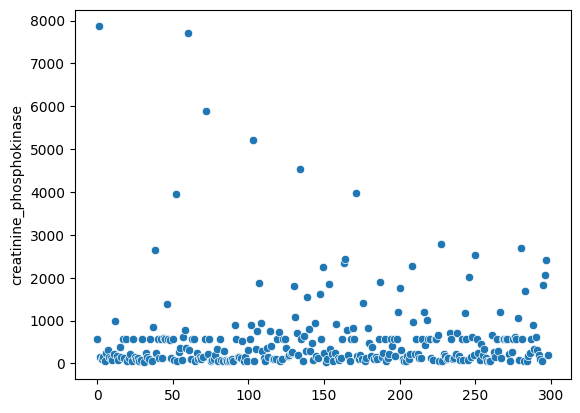

In [135]:
sns.scatterplot(base_metrics_patient_df.creatinine_phosphokinase)

Based off of the graph above, most values are condensed to under levels of 1000. I suggest removing rows for outliers above 1000 for analysis

In [136]:
# Merge the dataframes into one dataframe for easier analysis and fixing of outliers
master_df = demographic_df.merge(base_metrics_patient_df, on = 'uniqueID').merge(blood_metrics_df, left_on= 'uniqueID', right_on= 'unqiueID').merge(follow_up_df, on = 'uniqueID')

In [137]:
master_df.head()

,uniqueID,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,unqiueID,anaemia,high_blood_pressure,time,DEATH_EVENT
0,0,75.0,1,0,20,130,265000.00,582,0,1.9,0,0,1,4,1
1,1,55.0,1,0,38,136,263358.03,7861,0,1.1,1,0,0,6,1
2,2,65.0,1,1,20,129,162000.00,146,0,1.3,2,0,0,7,1
3,3,50.0,1,0,20,137,210000.00,111,0,1.9,3,1,0,7,1
4,4,65.0,0,0,20,116,327000.00,160,1,2.7,4,1,0,8,1


In [138]:
# Drop one of the unique columns as only one is needed
master_df = master_df.drop('unqiueID', axis = 1)
master_df.head()

,uniqueID,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,DEATH_EVENT
0,0,75.0,1,0,20,130,265000.00,582,0,1.9,0,1,4,1
1,1,55.0,1,0,38,136,263358.03,7861,0,1.1,0,0,6,1
2,2,65.0,1,1,20,129,162000.00,146,0,1.3,0,0,7,1
3,3,50.0,1,0,20,137,210000.00,111,0,1.9,1,0,7,1
4,4,65.0,0,0,20,116,327000.00,160,1,2.7,1,0,8,1


In [139]:
#Create copy of dataframe to work on
df_copy = master_df.copy()

In [140]:
df_copy.head()

,uniqueID,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,DEATH_EVENT
0,0,75.0,1,0,20,130,265000.00,582,0,1.9,0,1,4,1
1,1,55.0,1,0,38,136,263358.03,7861,0,1.1,0,0,6,1
2,2,65.0,1,1,20,129,162000.00,146,0,1.3,0,0,7,1
3,3,50.0,1,0,20,137,210000.00,111,0,1.9,1,0,7,1
4,4,65.0,0,0,20,116,327000.00,160,1,2.7,1,0,8,1


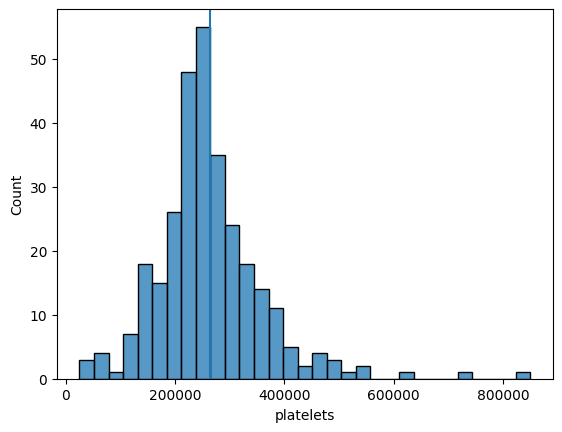

In [141]:
sns.histplot(df_copy.platelets)
plt.axvline(df_copy.platelets.mean())

In [142]:
# view all rows with over 800000 in platelets data
df_copy[df_copy['platelets'] > 800000]

,uniqueID,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,DEATH_EVENT
109,109,45.0,1,1,35,142,850000.0,292,1,1.3,0,0,88,0


## 2. Data Cleaning

### Outliers
- Remove outliers of creatinine_phosphokinase where values are over 1000

In [143]:
df_copy = df_copy[df_copy['creatinine_phosphokinase'] < 1000] 

In [144]:
df_copy.creatinine_phosphokinase.describe()

count    263.000000
mean     310.882129
std      247.586143
min       23.000000
25%      109.000000
50%      211.000000
75%      582.000000
max      981.000000
Name: creatinine_phosphokinase, dtype: float64

### Outliers
- Remove row with index 109 which is the row with the high plateletes level of over 800,000

In [145]:
#remove row 109 from datafraframe
df_copy = df_copy.drop(df_copy[df_copy['uniqueID'] == 109].index)

### Outliers
- Look for outliers for the serum Creatinine, see if there are multiple outliers

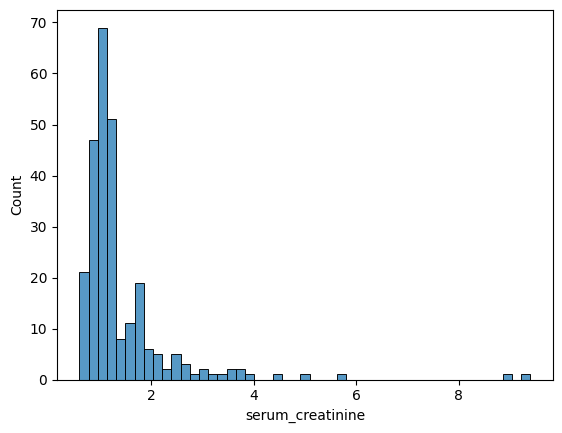

In [146]:
sns.histplot(df_copy.serum_creatinine);

> Remove rows that have serum creatinine values above 8

In [147]:
df_copy = df_copy.drop(df_copy[df_copy['serum_creatinine'] > 8].index)

### Outliers
- Remove any rows that have an ejection fraction above 70

<AxesSubplot: xlabel='ejection_fraction', ylabel='Count'>

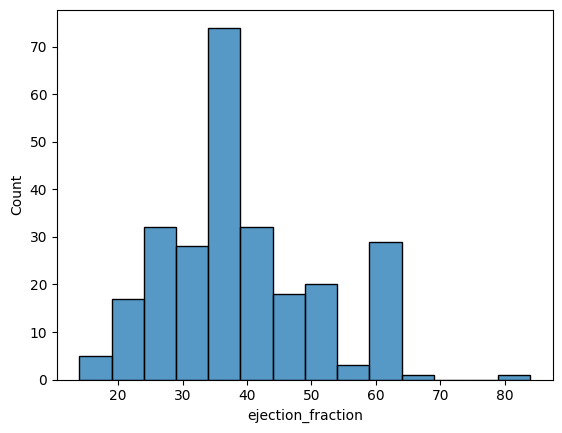

In [148]:
sns.histplot(df_copy.ejection_fraction, bins= 10, binwidth= 5)

In [149]:
df_copy = df_copy.drop(df_copy[df_copy['ejection_fraction'] > 70].index)
df_copy.ejection_fraction.describe()

count    259.000000
mean      37.907336
std       11.676813
min       14.000000
25%       30.000000
50%       38.000000
75%       45.000000
max       65.000000
Name: ejection_fraction, dtype: float64

### Re-name columns
- Change the column name for death event to all lower case to be consistant with the rest of the columns
- uniqueID should be changed to unique_id to use underscores as spaces between words to be like the rest of the columns

In [150]:
df_copy = df_copy.rename(columns= {'DEATH_EVENT': 'death_event', 'uniqueID': 'unique_id'})
df_copy.columns

Index(['unique_id', 'age', 'sex', 'smoking', 'ejection_fraction',
       'serum_sodium', 'platelets', 'creatinine_phosphokinase', 'diabetes',
       'serum_creatinine', 'anaemia', 'high_blood_pressure', 'time',
       'death_event'],
      dtype='object')

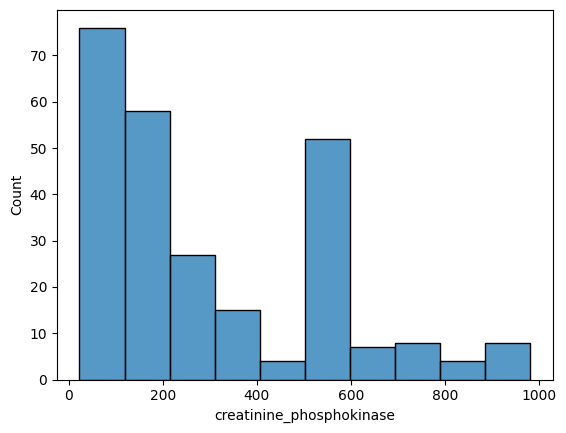

In [151]:
sns.histplot(df_copy.creatinine_phosphokinase, bins= 10,);

<AxesSubplot: xlabel='serum_creatinine', ylabel='Count'>

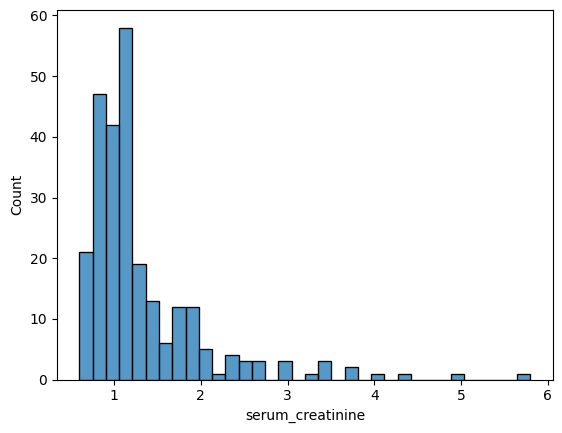

In [152]:
sns.histplot(df_copy.serum_creatinine)

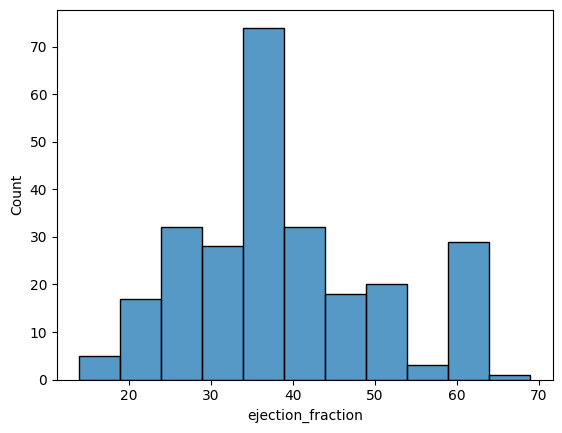

In [153]:
    sns.histplot(df_copy.ejection_fraction, bins= 5, binwidth= 5);

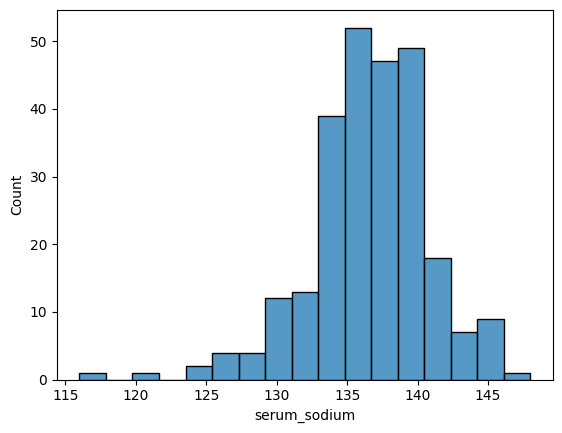

In [154]:
sns.histplot(df_copy.serum_sodium);

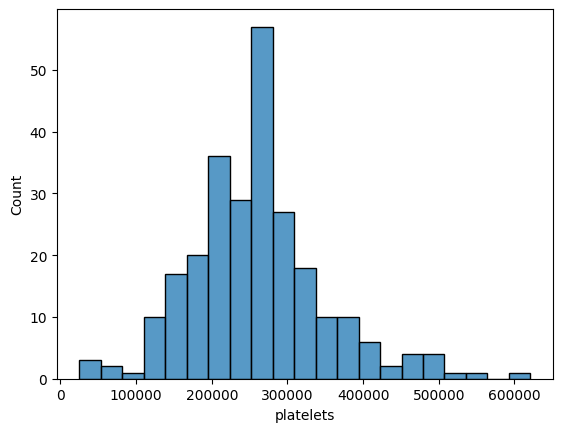

In [155]:
sns.histplot(df_copy.platelets);

### Summary:
- Looking at each of the metrics that are not boolean values (1 or 0), most metrics seem to have an even distribution. However, there are columns that are right skewed or left skewed, specifcally, serum sodium, serum creatinine, and creatinine_phosphokinase. Seeing this, these metrics may change based on if a patient has diabetes or is a smoker.

In [156]:
df_copy.corr()

,unique_id,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,death_event
unique_id,1.000000,-0.241703,0.017015,-0.023381,0.061856,0.095151,0.013958,0.062421,0.040779,-0.159387,-0.154431,-0.200616,0.995161,-0.572487
age,-0.241703,1.000000,0.067749,-0.002038,0.074428,-0.014257,-0.009799,0.001135,-0.086682,0.198150,0.073575,0.092485,-0.241034,0.284118
sex,0.017015,0.067749,1.000000,0.445021,-0.112993,0.030493,-0.137444,0.003544,-0.160756,0.054197,-0.080673,-0.104563,0.023531,0.002788
smoking,-0.023381,-0.002038,0.445021,1.000000,-0.054884,0.052280,0.019637,-0.038603,-0.132906,-0.054815,-0.091342,-0.036539,-0.018790,0.001433
ejection_fraction,0.061856,0.074428,-0.112993,-0.054884,1.000000,0.185536,0.092931,-0.071568,0.015502,-0.175974,0.018534,0.028738,0.049979,-0.280407
serum_sodium,0.095151,-0.014257,0.030493,0.052280,0.185536,1.000000,0.043141,-0.073768,-0.103658,-0.292456,0.051952,0.041490,0.089549,-0.237016
platelets,0.013958,-0.009799,-0.137444,0.019637,0.092931,0.043141,1.000000,-0.002932,0.041100,-0.079686,0.023412,0.074465,0.013802,-0.057209
creatinine_phosphokinase,0.062421,0.001135,0.003544,-0.038603,-0.071568,-0.073768,-0.002932,1.000000,0.035745,-0.068923,-0.198432,-0.025100,0.051968,0.035125
diabetes,0.040779,-0.086682,-0.160756,-0.132906,0.015502,-0.103658,0.041100,0.035745,1.000000,-0.092781,-0.035191,0.039687,0.045709,-0.005870
serum_creatinine,-0.159387,0.198150,0.054197,-0.054815,-0.175974,-0.292456,-0.079686,-0.068923,-0.092781,1.000000,-0.009736,-0.065749,-0.154640,0.315725


### Notes from above:
- Based on this dataset there isn't much correlation between each column, but some with the highest are:
	- diabetes and serum sodium
	- serum creatinine and serum sodium
	- Death event with both ejection fraction and serum sodium

## Questions to ask:
1. What is the comparison in data between male and females with smoking and non smoking in platelets, both creatinine levels, and ejection fraction
2. Looking at this data alone, does being a smoker alone, or diabetic alone, create a higher risk of heart failure?
3. Does having lower then normal levels or higher then normal levels increase risk of heart failure?
4. Does age groups play a factor on likliness to have levels enough for heart failure?


> Before moving to any analysis, a column that groups ages into ages should be created to help bucket the ages into categories

In [157]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259 entries, 0 to 298
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   unique_id                 259 non-null    int64  
 1   age                       259 non-null    float64
 2   sex                       259 non-null    int64  
 3   smoking                   259 non-null    int64  
 4   ejection_fraction         259 non-null    int64  
 5   serum_sodium              259 non-null    int64  
 6   platelets                 259 non-null    float64
 7   creatinine_phosphokinase  259 non-null    int64  
 8   diabetes                  259 non-null    int64  
 9   serum_creatinine          259 non-null    float64
 10  anaemia                   259 non-null    int64  
 11  high_blood_pressure       259 non-null    int64  
 12  time                      259 non-null    int64  
 13  death_event               259 non-null    int64  
dtypes: float64

In [158]:
#Create a list that represents each age group category. This will be used to iterate through the ages column and assign it to the appropriate category.
age_group_list = [
    '10 < x ≤ 50',  
    '50 < x ≤ 70', 
    '70 < x ≤ 80',
    '80 < x ≤ 120'
]
#iterate through each row in the dataframe, checking what age is equal to and assigning the proper string in the list to age_group
for i, row in df_copy.iterrows():
    age = row['age']
    if 10 < age <= 50:
        df_copy.loc[i, 'age_group'] = age_group_list[0]
    elif 50 < age <= 70:
        df_copy.loc[i, 'age_group'] = age_group_list[1]
    elif 70 < age <= 80:
        df_copy.loc[i, 'age_group'] = age_group_list[2]
    elif 80 < age <= 120:
        df_copy.loc[i, 'age_group'] = age_group_list[3]




In [159]:

df_copy.head()

,unique_id,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,death_event,age_group
0,0,75.0,1,0,20,130,265000.0,582,0,1.9,0,1,4,1,70 < x ≤ 80
2,2,65.0,1,1,20,129,162000.0,146,0,1.3,0,0,7,1,50 < x ≤ 70
3,3,50.0,1,0,20,137,210000.0,111,0,1.9,1,0,7,1,10 < x ≤ 50
4,4,65.0,0,0,20,116,327000.0,160,1,2.7,1,0,8,1,50 < x ≤ 70
5,5,90.0,1,1,40,132,204000.0,47,0,2.1,1,1,8,1,80 < x ≤ 120


In [160]:
#Change the data in the columns that use 1 or 0 to labels.
df_copy['sex'].replace({1: 'male', 0: 'female'}, inplace= True)
df_copy['diabetes'].replace({1: 'diabetic', 0: 'non-diabetic'}, inplace= True)
df_copy['smoking'].replace({1: 'smoking', 0: 'non-smoking'}, inplace= True)
df_copy['anaemia'].replace({1: 'anaemia', 0: 'non-anaemia'}, inplace= True)
df_copy['high_blood_pressure'].replace({1:'yes', 0:'no'}, inplace= True)
df_copy['death_event'].replace({1: 'deceased', 0: 'not-deceased'}, inplace= True)

In [161]:
df_copy.head()

,unique_id,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,death_event,age_group
0,0,75.0,male,non-smoking,20,130,265000.0,582,non-diabetic,1.9,non-anaemia,yes,4,deceased,70 < x ≤ 80
2,2,65.0,male,smoking,20,129,162000.0,146,non-diabetic,1.3,non-anaemia,no,7,deceased,50 < x ≤ 70
3,3,50.0,male,non-smoking,20,137,210000.0,111,non-diabetic,1.9,anaemia,no,7,deceased,10 < x ≤ 50
4,4,65.0,female,non-smoking,20,116,327000.0,160,diabetic,2.7,anaemia,no,8,deceased,50 < x ≤ 70
5,5,90.0,male,smoking,40,132,204000.0,47,non-diabetic,2.1,anaemia,yes,8,deceased,80 < x ≤ 120


In [162]:
#create a dataframe that is just smoker as well as diabetes to do analysis of.
smoker_df = df_copy[df_copy['smoking'] == 'smoking']
smoker_df.head()

,unique_id,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,death_event,age_group
2,2,65.0,male,smoking,20,129,162000.0,146,non-diabetic,1.3,non-anaemia,no,7,deceased,50 < x ≤ 70
5,5,90.0,male,smoking,40,132,204000.0,47,non-diabetic,2.1,anaemia,yes,8,deceased,80 < x ≤ 120
7,7,60.0,male,smoking,60,131,454000.0,315,diabetic,1.1,anaemia,no,10,deceased,50 < x ≤ 70
10,10,75.0,male,smoking,38,131,368000.0,81,non-diabetic,4.0,anaemia,yes,10,deceased,70 < x ≤ 80
11,11,62.0,male,smoking,25,140,253000.0,231,non-diabetic,0.9,non-anaemia,yes,10,deceased,50 < x ≤ 70


In [163]:
diabetes_df = df_copy[df_copy['diabetes'] == 'diabetic']

In [164]:
diabetes_smoker_df = smoker_df.merge(diabetes_df, on = 'unique_id')

In [165]:
diabetes_smoker_df.head()

,unique_id,age_x,sex_x,smoking_x,ejection_fraction_x,serum_sodium_x,platelets_x,creatinine_phosphokinase_x,diabetes_x,serum_creatinine_x,anaemia_x,high_blood_pressure_x,time_x,death_event_x,age_group_x,age_y,sex_y,smoking_y,ejection_fraction_y,serum_sodium_y,platelets_y,creatinine_phosphokinase_y,diabetes_y,serum_creatinine_y,anaemia_y,high_blood_pressure_y,time_y,death_event_y,age_group_y
0,7,60.0,male,smoking,60,131,454000.0,315,diabetic,1.1,anaemia,no,10,deceased,50 < x ≤ 70,60.0,male,smoking,60,131,454000.0,315,diabetic,1.1,anaemia,no,10,deceased,50 < x ≤ 70
1,25,80.0,male,smoking,38,144,149000.0,148,diabetic,1.9,non-anaemia,no,23,deceased,70 < x ≤ 80,80.0,male,smoking,38,144,149000.0,148,diabetic,1.9,non-anaemia,no,23,deceased,70 < x ≤ 80
2,27,70.0,male,smoking,45,136,284000.0,122,diabetic,1.3,non-anaemia,yes,26,deceased,50 < x ≤ 70,70.0,male,smoking,45,136,284000.0,122,diabetic,1.3,non-anaemia,yes,26,deceased,50 < x ≤ 70
3,29,82.0,male,smoking,30,132,200000.0,70,diabetic,1.2,non-anaemia,no,26,deceased,80 < x ≤ 120,82.0,male,smoking,30,132,200000.0,70,diabetic,1.2,non-anaemia,no,26,deceased,80 < x ≤ 120
4,41,50.0,female,smoking,30,136,153000.0,124,diabetic,1.2,non-anaemia,yes,32,deceased,10 < x ≤ 50,50.0,female,smoking,30,136,153000.0,124,diabetic,1.2,non-anaemia,yes,32,deceased,10 < x ≤ 50


In [166]:
def smoking_barplot (x, y, hue):
    sns.barplot(data= df_copy, x=x, y=y, hue= hue, palette= 'Blues')

# Question 1
What is the comparison in data between male and females with smoking and non smoking in platelets, both creatinine levels, and ejection fraction

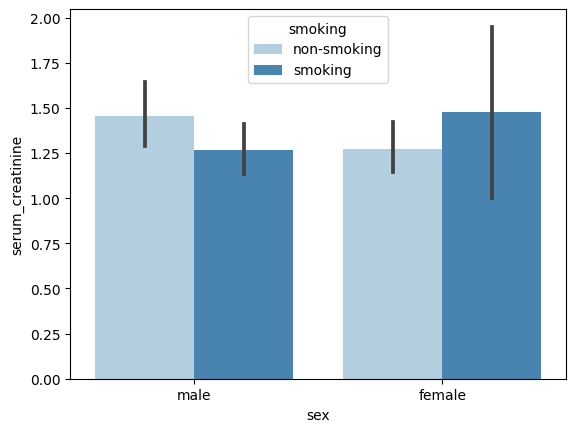

In [167]:
smoking_barplot('sex', 'serum_creatinine', 'smoking');

### Note:
> Interesting to see that non-smoking male levels are higher then females, but males on average have lower levels when they smoke, compared to non smoking, and are also lower then non smoking females.

### Notes:
> Female levels drop a significant amount as a smoker compared to a non-smokers. Males there is not much of a drop.

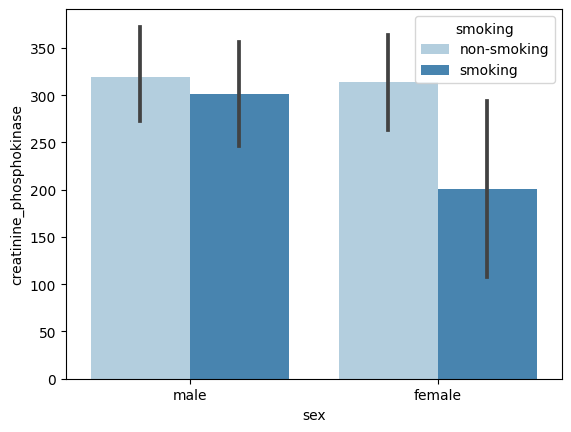

In [168]:
smoking_barplot('sex', 'creatinine_phosphokinase', 'smoking')

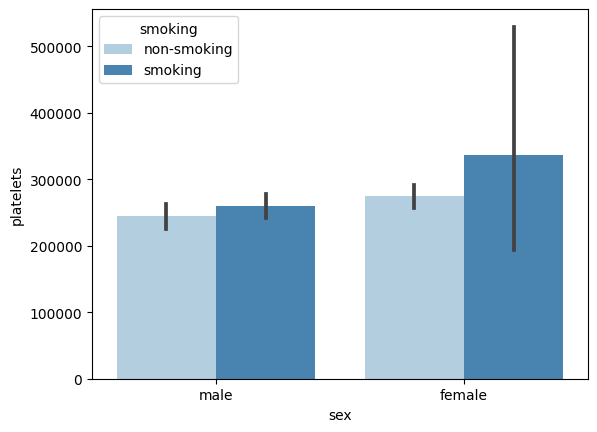

In [169]:
smoking_barplot('sex', 'platelets', 'smoking')

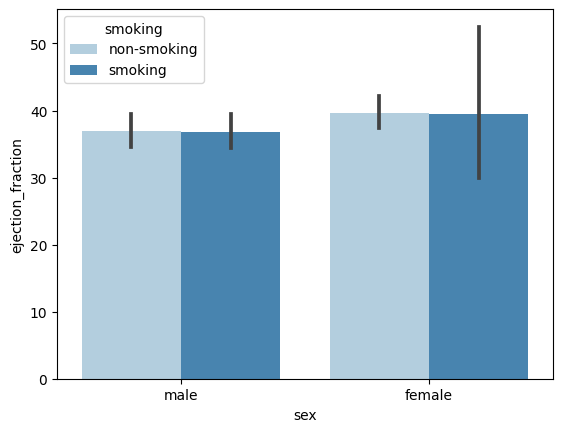

In [170]:
smoking_barplot('sex', 'ejection_fraction', 'smoking')

### Question 1 Summary:
> In these different levels, females see more of a difference in levels then males do. Males tend to not change in levels much. For question 2 when it comes to the death rate, I'll explore if females are at a greater risk, as comparing these stats so far seem to think so.

# Question 2:
- Looking at this data alone, does being a smoker alone, or diabetic alone, create a higher risk of heart failure? Is there age groups with a higher risk?

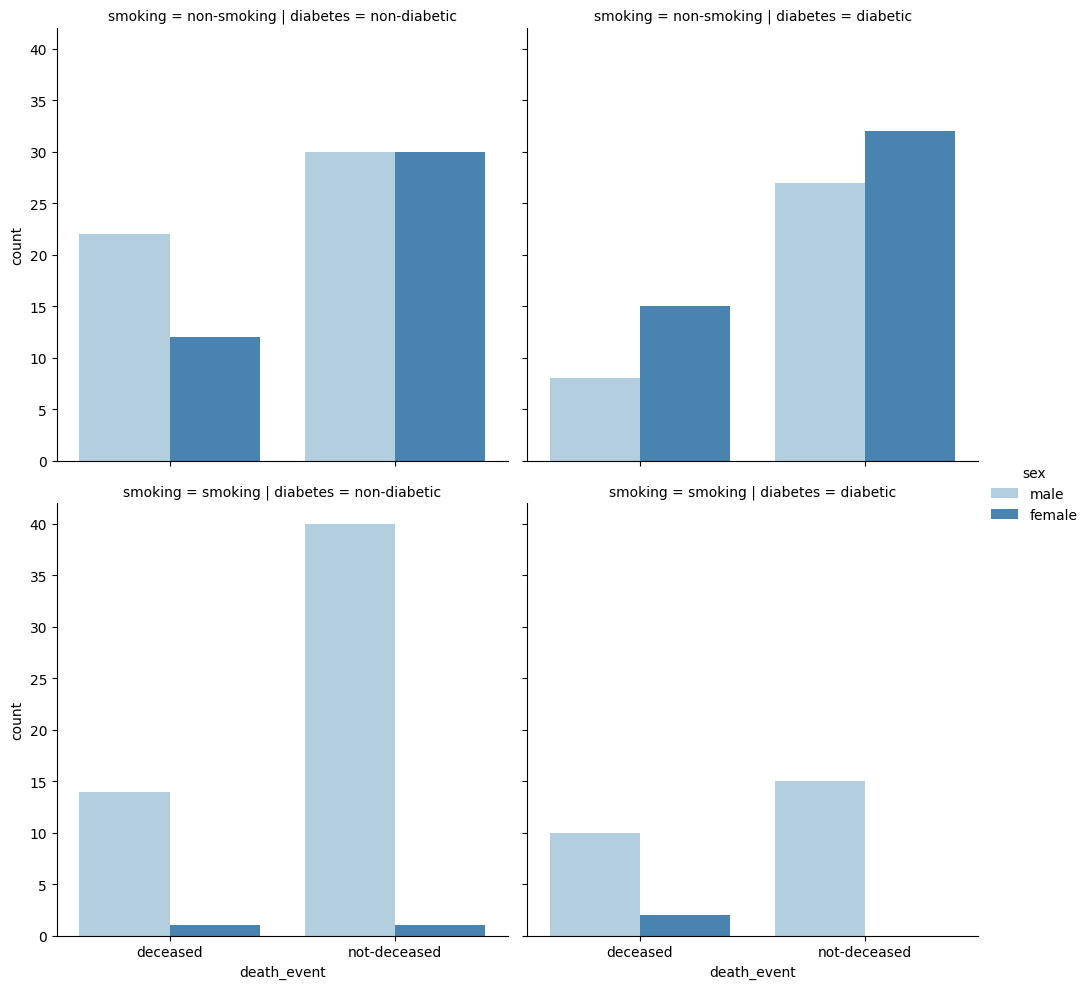

In [171]:
sns.catplot(data= df_copy, x= 'death_event', hue= 'sex', row= 'smoking', col= 'diabetes', kind= 'count',
           palette= 'Blues')

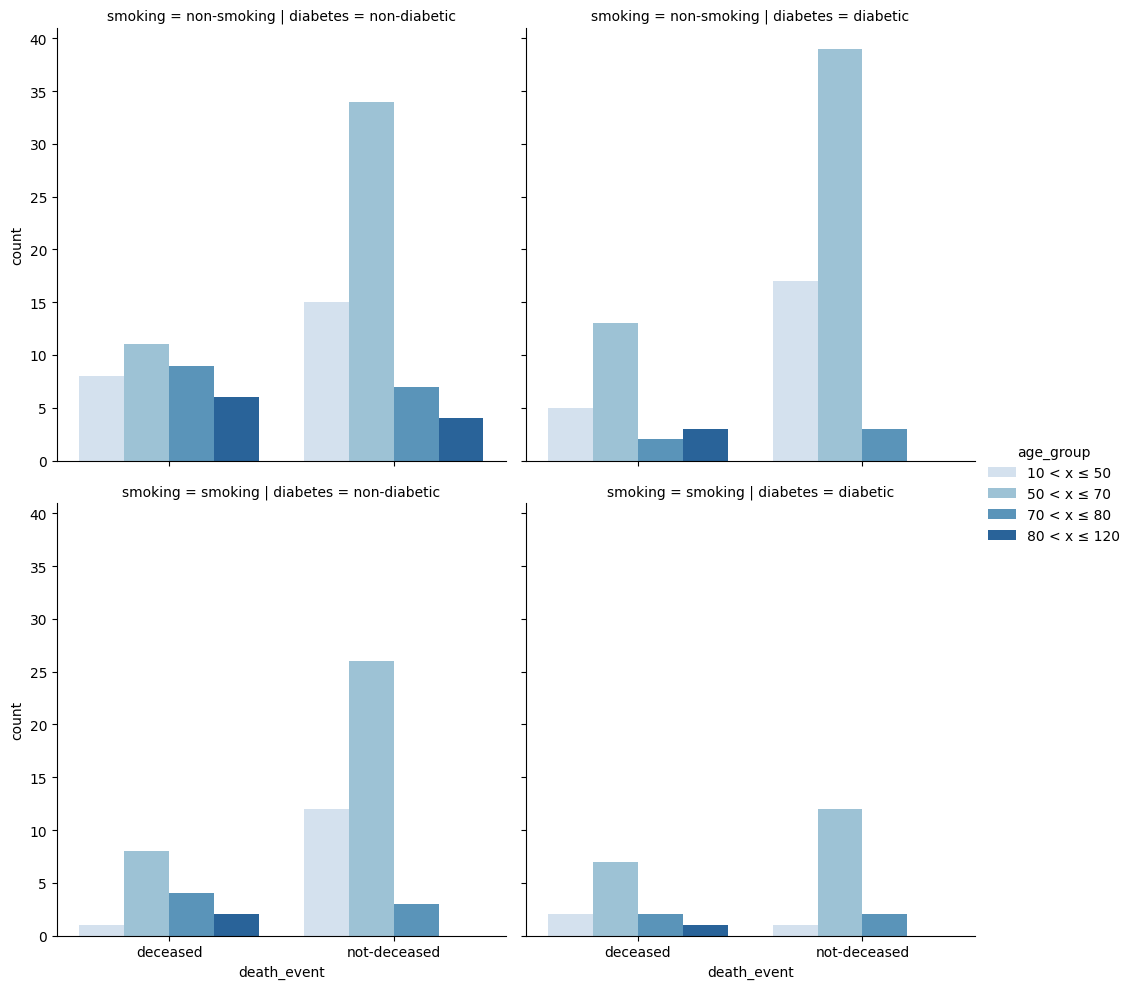

In [172]:
sns.catplot(data= df_copy, x= 'death_event', hue= 'age_group', row= 'smoking', col= 'diabetes', kind= 'count', hue_order= ['10 < x ≤ 50',  
    '50 < x ≤ 70', 
    '70 < x ≤ 80',
    '80 < x ≤ 120'], palette= 'Blues')

### Question 2 Summary:
> Based off of the findings from above, it seems that just being labelled as a smoker or diabetic does not mean a higher risk of heart failure. There could be reasons for this such as a diabetic can keep their levels healthy, or possibly a smoker that isn't heavy on the smokes. A follow up would be if more elevated levels or lower then normal levels, along with being labelled as a smoker or diabetic has an increased chance in heart failure.

# Question 3
- Does having lower then normal levels or higher then normal levels increase risk of heart failure? Analysis in Tableau already shows that diabetes or being a smoker does play a big factor and changing the levels of a patient of different metrics. So,I'll need to seperate patients based on bracket levels similar to age_group, and compare the levels.

> To answer this question, when comparing each levels, I'll need to split the levels so I can compare, I'll make new columns in the dataset for each metrics labelled low, normal, high, and do some analysis on that.

## Platelets

<AxesSubplot: xlabel='platelets', ylabel='Count'>

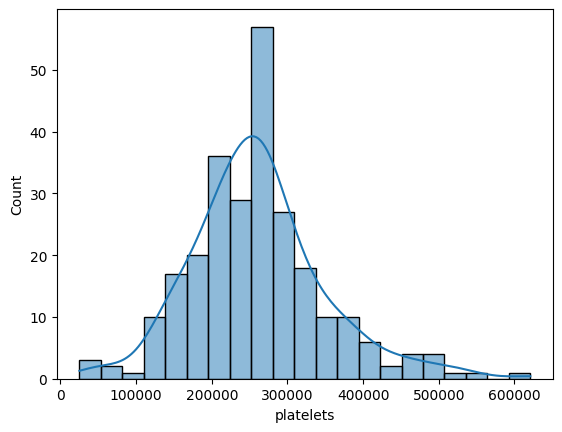

In [173]:
#Use histograms to find low, normal and high levels for each metric
sns.histplot(df_copy.platelets, kde= True)


In [174]:
df_copy.platelets.describe()

count       259.000000
mean     260797.469266
std       88905.778704
min       25100.000000
25%      210000.000000
50%      260000.000000
75%      302500.000000
max      621000.000000
Name: platelets, dtype: float64

According to different sources online, the most common range I am seeing for platelets is a normal level between 150,000 and 400,000, which also seems to be where most patients fall in this dataset. since 150,000 and 400,000 are borderline, I'll use the percentiles to help determine the bracket. The following bracket is:
- Low: 0-199,999
- Normal: 200,000- 350,000
- High: 350,001+


In [175]:
#Create a new column called platelets_level
for i, row in df_copy.iterrows():
    platelet = row['platelets']
    if platelet < 200000:
        df_copy.loc[i, 'platelets_level'] = 'Low'
    elif platelet >= 200000 and platelet <= 350000:
        df_copy.loc[i, 'platelets_level'] = 'Normal'
    elif platelet > 350000:
        df_copy.loc[i, 'platelets_level'] = 'High'

## Serum Sodium

<AxesSubplot: xlabel='serum_sodium', ylabel='Count'>

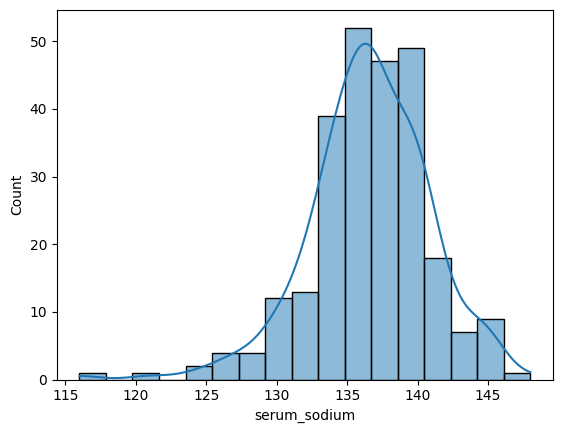

In [176]:
# Create histogram for spread of values for serum sodium
sns.histplot(df_copy.serum_sodium, kde= True)

> Normal levels for Serum Sodium is between 135 and 145. The follwing range as follows:
> - Low: Less then 135
> - Normal 135-145 (inclusive)
> - High: greater then 145

In [177]:
for i, row in df_copy.iterrows():
    sodium = row['serum_sodium']
    if sodium < 135:
        df_copy.loc[i, 'serum_sodium_level'] = 'Low'
    elif sodium >= 135 and sodium <= 145:
        df_copy.loc[i, 'serum_sodium_level'] = 'Normal'
    elif sodium > 145:
        df_copy.loc[i, 'serum_sodium_level'] = 'High'

## Serum Creatinine

<AxesSubplot: xlabel='serum_creatinine', ylabel='Count'>

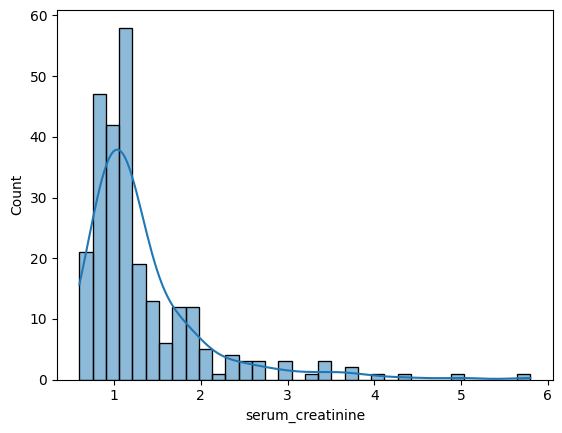

In [178]:
# Create Histogram to see distribtuion of values to help create range
sns.histplot(df_copy.serum_creatinine, kde= True)

> Serum Creatinine is a little different, as what is considered normal is different for males and females. The Mayo clinic suggests the following:
> - Female:
> 	- Normal levels are 0.59 to 1.04
> - Male:
> 	- Normal levels are 0.74 to 1.35
>To keep the data as accurate as possible, especially since this is a small dataset, I will create ranges for each gender instead of averaging the stats.
>The following ranges will be as followed:
>- Male:
>	- Less than 0.74: Low
>	- 0.74-1.35(inclusive): Normal
>	- Greater then 1.35: High
>- Female:
>	- Less than 0.59: Low
>	- 0.59-1.04 (inclusive): Normal
>	- Greater than 1.04: High

In [179]:
'''iterate through the rows of the data set, checking if the patient is male or Female, then check the serum creatine levels and put in the proper range'''
for i, row in df_copy.iterrows():
    creatinine = row['serum_creatinine']
    sex = row['sex']
    if sex == 'male':
        if creatinine < 0.74:
            df_copy.loc[i, 'serum_creatinine_level'] = 'Low'
        elif creatinine >= 0.74 and creatinine <= 1.35:
            df_copy.loc[i, 'serum_creatinine_level'] = 'Normal'
        elif creatinine > 1.35:
            df_copy.loc[i, 'serum_creatinine_level'] = 'High'
    elif sex == 'female':
        if creatinine < 0.59:
            df_copy.loc[i, 'serum_creatinine_level'] = 'Low'
        elif creatinine >= 0.59 and creatinine <= 1.04:
            df_copy.loc[i, 'serum_creatinine_level'] = 'Normal'
        elif creatinine > 1.04:
            df_copy.loc[i, 'serum_creatinine_level'] = 'High'

In [180]:
df_copy.head()

,unique_id,age,sex,smoking,ejection_fraction,serum_sodium,platelets,creatinine_phosphokinase,diabetes,serum_creatinine,anaemia,high_blood_pressure,time,death_event,age_group,platelets_level,serum_sodium_level,serum_creatinine_level
0,0,75.0,male,non-smoking,20,130,265000.0,582,non-diabetic,1.9,non-anaemia,yes,4,deceased,70 < x ≤ 80,Normal,Low,High
2,2,65.0,male,smoking,20,129,162000.0,146,non-diabetic,1.3,non-anaemia,no,7,deceased,50 < x ≤ 70,Low,Low,Normal
3,3,50.0,male,non-smoking,20,137,210000.0,111,non-diabetic,1.9,anaemia,no,7,deceased,10 < x ≤ 50,Normal,Normal,High
4,4,65.0,female,non-smoking,20,116,327000.0,160,diabetic,2.7,anaemia,no,8,deceased,50 < x ≤ 70,Normal,Low,High
5,5,90.0,male,smoking,40,132,204000.0,47,non-diabetic,2.1,anaemia,yes,8,deceased,80 < x ≤ 120,Normal,Low,High


## creatinine_phosphokinase

<AxesSubplot: xlabel='creatinine_phosphokinase', ylabel='Count'>

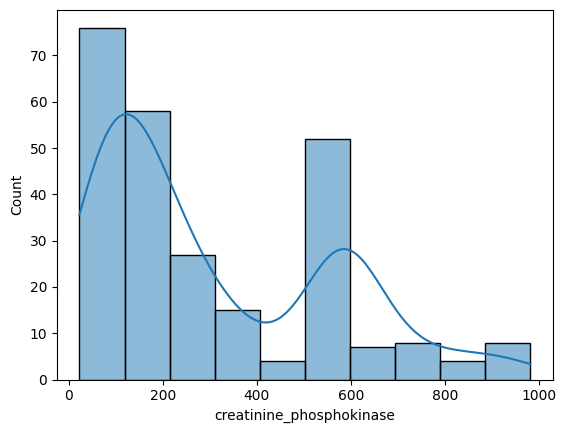

In [181]:
# Create a histogram to look at values
sns.histplot(df_copy.creatinine_phosphokinase, kde= True)

>A common value of a normal level is 10-120 mcg/L.
>The following  will be used for range:
>- Less than 10: Low
>- 10 to 120 (inclusive): Normal
>- Greater than 120: High

In [182]:
#Itereate through the rows in the dataset, adding the strings above to a new column: creatinine_phosphokinase_levels
for i, row in df_copy.iterrows():
    creatinine = row['creatinine_phosphokinase']
    if creatinine < 10:
        df_copy.loc[i, 'creatinine_phosphokinase_level'] = 'Low'
    elif creatinine >= 10 and creatinine <= 120:
        df_copy.loc[i, 'creatinine_phosphokinase_level'] = 'Normal'
    elif creatinine > 120:
        df_copy.loc[i, 'creatinine_phosphokinase_level'] = 'High'

### Ejection Fraction

<AxesSubplot: xlabel='ejection_fraction', ylabel='Count'>

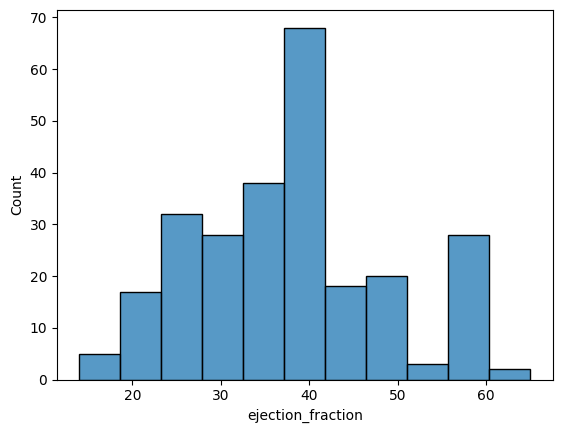

In [183]:
sns.histplot(df_copy.ejection_fraction)

>A normal ejection fraction is between 50 - 75% according to [Mayo Clinic](https://www.mayoclinic.org/tests-procedures/ekg/expert-answers/ejection-fraction/faq-20058286)

>The following range will be used:
>- Less then 50%: Low
>- Between 50 and 75%(inclusive): Normal
>- Greater than 75%: High

In [184]:
#adding a new column, iterating through ejection_fraction and adding appropriate string to new column: ejection_fraction_level
for i, row in df_copy.iterrows():
    ejection = row['ejection_fraction']
    if ejection < 50:
        df_copy.loc[i, 'ejection_fraction_level'] = 'Low'
    elif ejection >= 50 and ejection <= 75:
        df_copy.loc[i, 'ejection_fraction_level'] = 'Normal'
    elif ejection > 75:
        df_copy.loc[i, 'ejection_fraction_level'] = 'High'

> Now that the metrics are set up in levels, a proper analysis can be made to compare different levels of each metric and see if there are greater risks for heart failure

<AxesSubplot: xlabel='serum_creatinine_level', ylabel='count'>

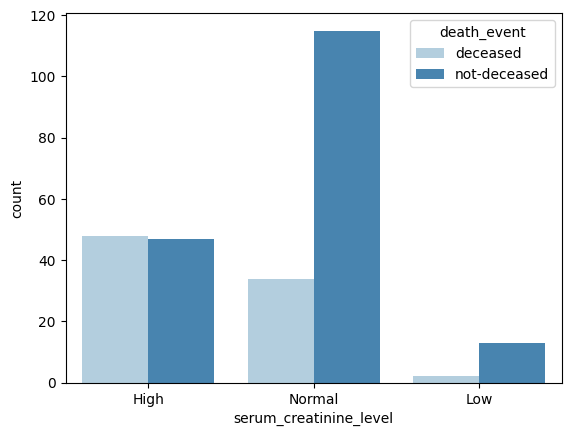

In [185]:
sns.countplot(x= df_copy.serum_creatinine_level, hue= df_copy.death_event, palette= 'Blues')

<AxesSubplot: xlabel='creatinine_phosphokinase_level', ylabel='count'>

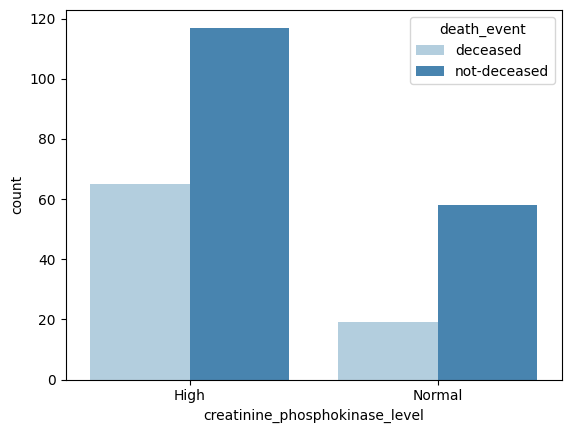

In [186]:
sns.countplot(x= df_copy.creatinine_phosphokinase_level, hue= df_copy.death_event, palette= 'Blues')

<AxesSubplot: xlabel='platelets_level', ylabel='count'>

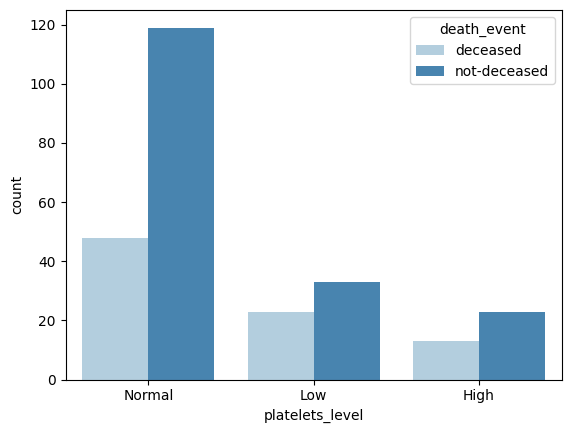

In [187]:
sns.countplot(x= df_copy.platelets_level, hue= df_copy.death_event, palette= 'Blues')

<AxesSubplot: xlabel='serum_sodium_level', ylabel='count'>

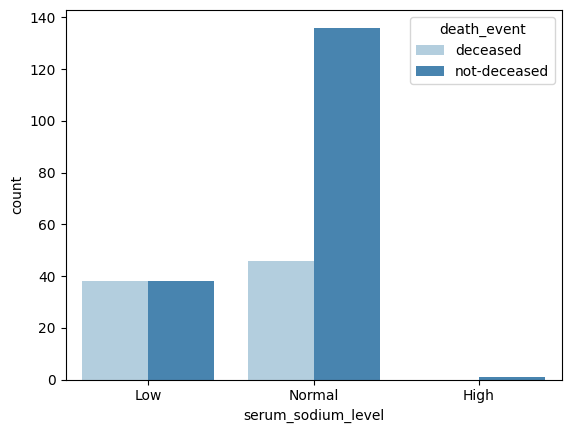

In [188]:
sns.countplot(x= df_copy.serum_sodium_level, hue= df_copy.death_event, palette= 'Blues')

<AxesSubplot: xlabel='ejection_fraction_level', ylabel='count'>

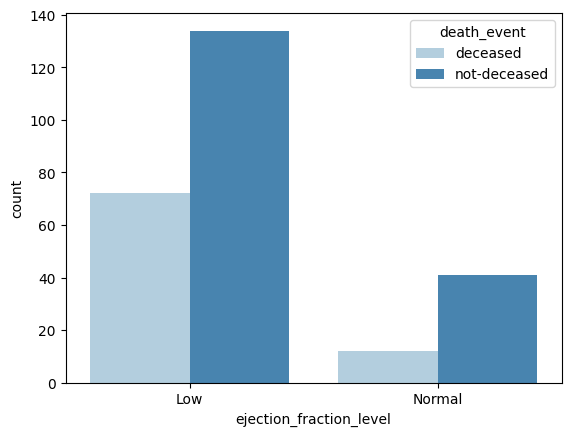

In [189]:
sns.countplot(x= df_copy.ejection_fraction_level, hue= df_copy.death_event, palette= 'Blues')

> Now that each metric was able to be looked at through a range, there is some key points to note:
> - serum_creatinine, creatinine phosphokinase with elevated levels have a higher death count.
> - Low ejection fraction has a higher death count then a normal level.
> - Does Anemia, being a smoker or diabetic be the reason these levels change?

## Question 4:
Does age groups play a factor on likliness to have levels enough for heart failure?

> Since have increased levels in some metrics and low levels in other metrics, and knowing that smoking and having diabetes affects these levels from the analysis in tableau, (see link and screen shot above), is there ages and age groups at greater risk of heart failure?

<AxesSubplot: xlabel='age_group', ylabel='creatinine_phosphokinase'>

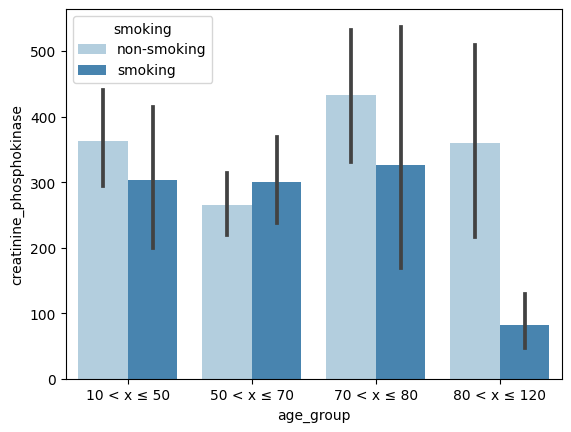

In [190]:
sns.barplot(x= df_copy.age_group, y= df_copy.creatinine_phosphokinase, hue= df_copy.smoking, palette= 'Blues',
           order= ['10 < x ≤ 50',  
    '50 < x ≤ 70', 
    '70 < x ≤ 80',
    '80 < x ≤ 120'
])

The older the age group, the higher the levels of creatinine phospokinase

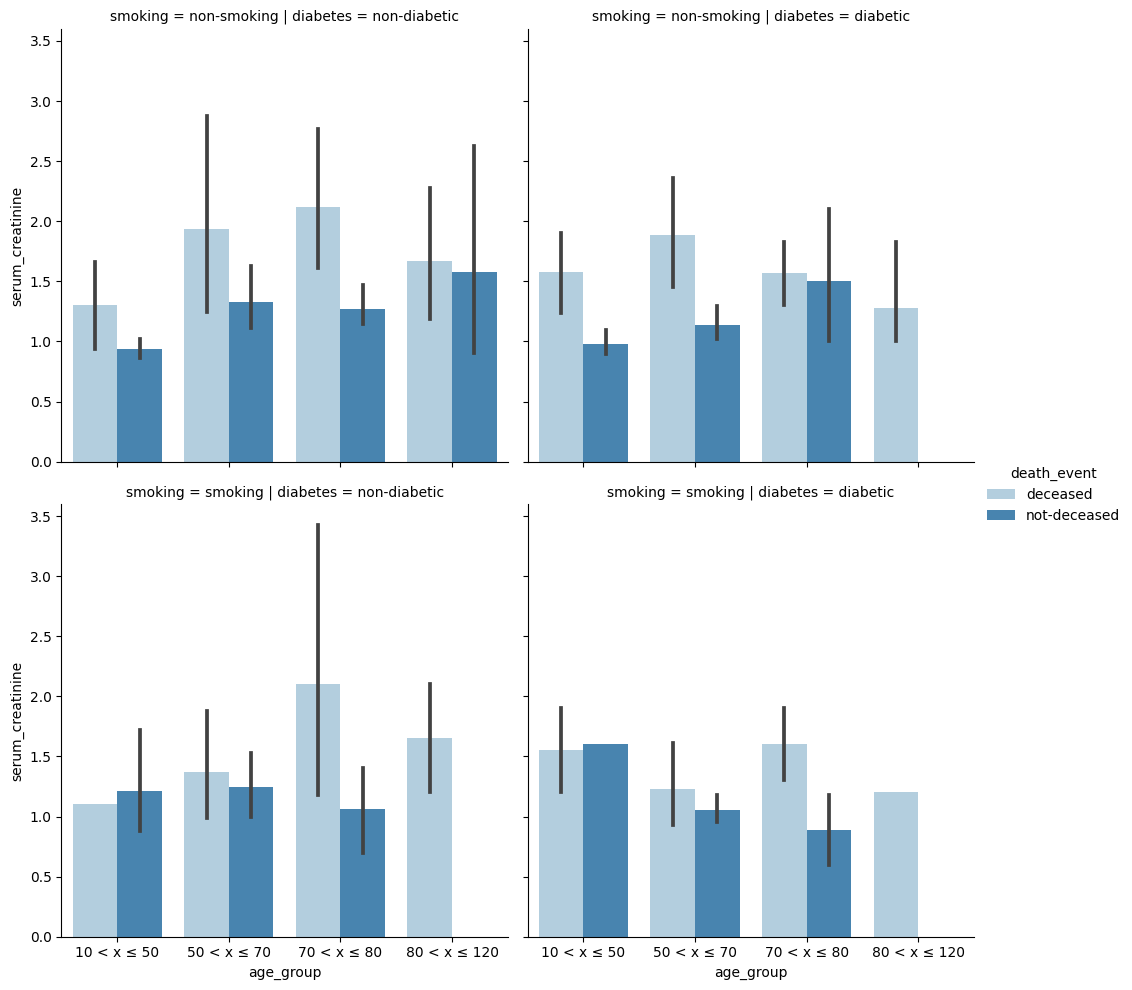

In [191]:
sns.catplot(data= df_copy, x= 'age_group', y= 'serum_creatinine',
            row= 'smoking',
            col= 'diabetes',
           kind= 'bar',
           hue= 'death_event',
           palette= 'Blues',
           order= [
    '10 < x ≤ 50',  
    '50 < x ≤ 70', 
    '70 < x ≤ 80',
    '80 < x ≤ 120'
])

When factoring in smoking and diabetes, there is a higher risk of heart failure, as higher levels of serum creatinine is found in those who have dides, regardless of age bracket.

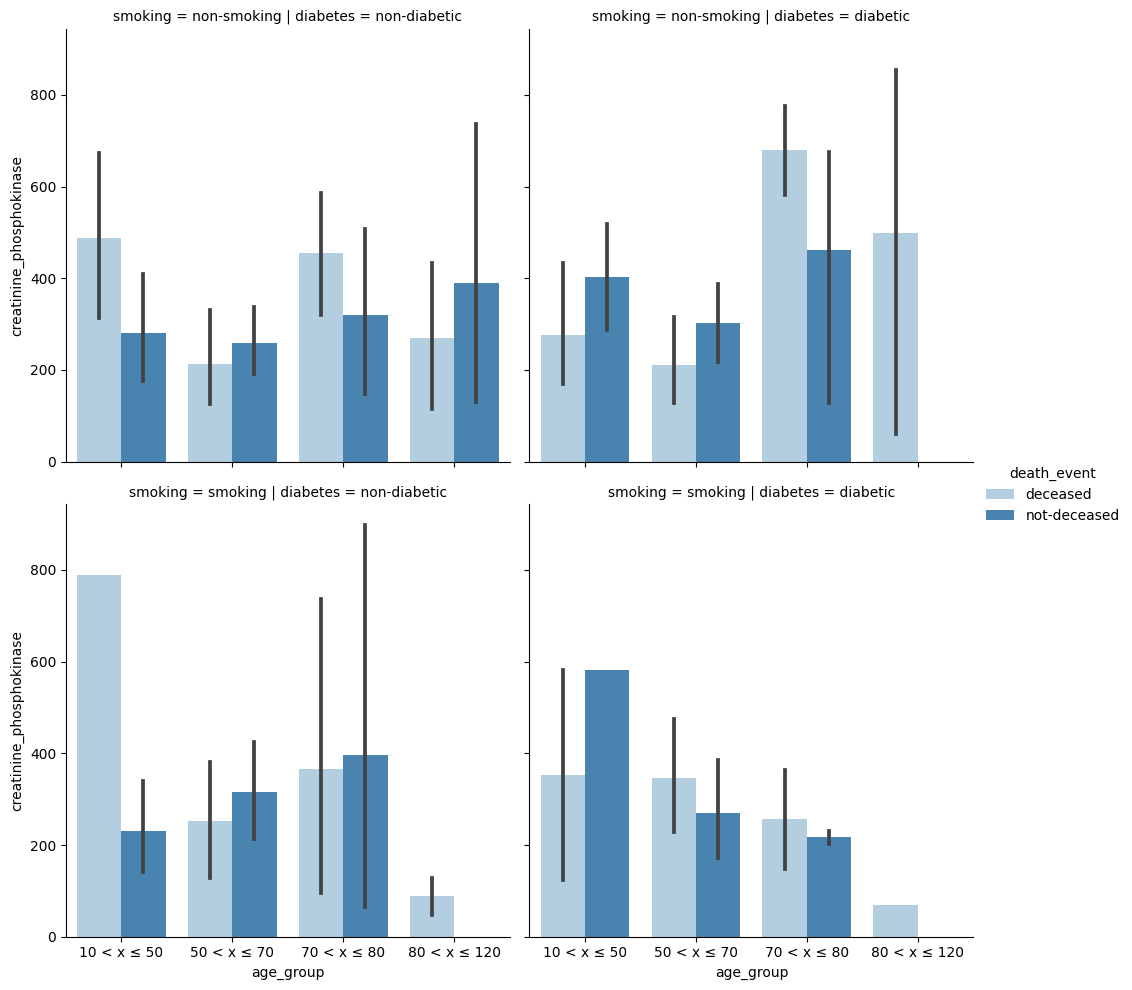

In [192]:
sns.catplot(data= df_copy, x= 'age_group', y= 'creatinine_phosphokinase',
            row= 'smoking',
            col= 'diabetes',
           kind= 'bar',
           hue= 'death_event',
           palette= 'Blues',
           order= [
    '10 < x ≤ 50',  
    '50 < x ≤ 70', 
    '70 < x ≤ 80',
    '80 < x ≤ 120'
])

The most drastic change seems to be in the 10 to 50 age bracket when being a smoker. Creatinine phosphokinase seem to have a large increase in that age group being a smoker in the deceased bracket. it also good to point at that the error line does not exist for that bar.

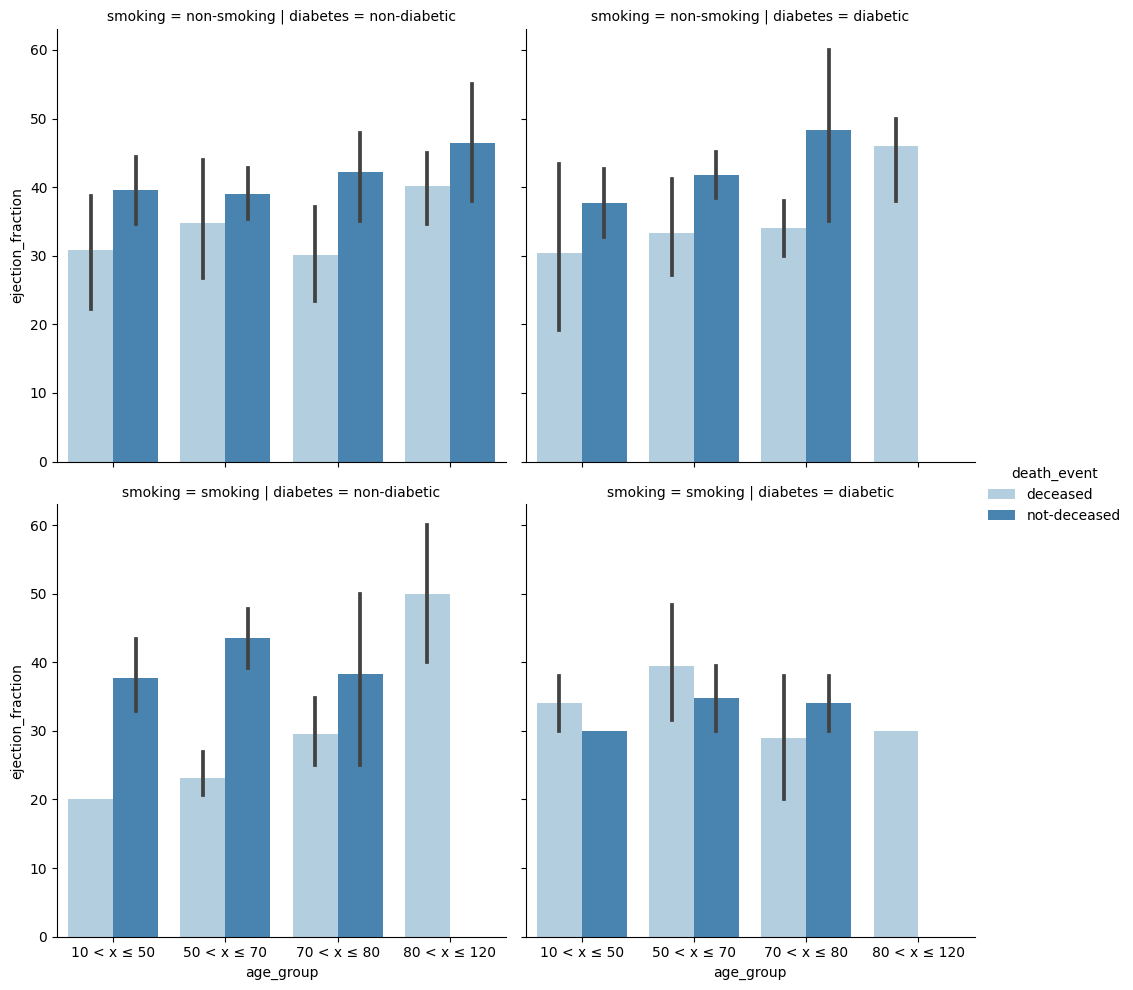

In [193]:
sns.catplot(data= df_copy, x= 'age_group', y= 'ejection_fraction',
            row= 'smoking',
            col= 'diabetes',
           kind= 'bar',
           hue= 'death_event',
           palette= 'Blues',
           order= [
    '10 < x ≤ 50',  
    '50 < x ≤ 70', 
    '70 < x ≤ 80',
    '80 < x ≤ 120'
])

Ejection fractions are lower in those that did eventually die, with levels being lower for those that are/were smokers, biggest change in the smoking category with ages between 10-50.

## Question 4 Summary:
> From question 3, it was discovered that the 3 metrics that would increase the higest risk would be high serum creatinine levels, high creatinine phosphokinase, and low ejection fraction. Going in depth by age group, while aging patients would be put at risk, being a smoker in the 10-50 group has a drastic change in levels, making them the highest concern for heart failure.

# Data Enrichment

While this data set was helpful in doing some analysis and coming up with some possible answers to whether we can find a way to predict when someone may be at a higher risk of heart failure, I feel that this data set may be too small.
The dataset only had 299 rows to begin with, and after cleaning it was narrowed down to 249. When categorizing these patients it left some categories with very little patients which can skew the results drastically.

An example, when seeing if just being a smoker or diabetic was a cause for heart failure, it did not show any difference or might have showed those patients to be slightly helathier or less of a risk. This could be do to not having enough data and depending on the severity of diabetes or smoking issue they have.

-Also in some graphs comparing male and females with certain metrics and whether a patient was deceased or not, there were no deceased males, which could falsly claim that a male that is a smoker and diabetic will not have heart issues or heart failure.

Another issue, is that the metrics alone that were given, may not tell the whole story of a patient, and there are many other factors that could play in the cardiovasuliar health of a patient which may include:
- Body fat percentage
- Cholestoral levels
- excerise frequency
- Actual blood pressure levels (not just a boolean value of high blood pressure)
- Blood sugar levels
- ECG
- level of smoker (how many cigerettes per day smoked as an example)
- time sitting compared to standing or moving in a day. (example, apple watch tracks amount of time standing per day)

### Recommendation
Even without worrying about a budget, I found a great dataset on [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)
which has these points I listed above and also has more observations than this data set which would give us a more accurate analysis.

With a great budget, gathering data from multiple hospitals from different locations, even as far as multiple countries would be great. Also increase the observations as the more there is, the more of an accurate analysis we would get. I would also add a sperate dataset linked by a patient ID if the patient actively wears fitness watches, could we get access to that data to check distance walked, accurate excercise minutes, heart rate throught the day, oxygen level, quality of sleep etc.
Some questions we may be able to ask then is:
1. Is there an increase in heart failure based on location or access to good health care?
2. How does the patients lifestyle affect the risk?(excerise level, smoker level etc.)
3. What types of eating habits affect the risk of heart failure
4. how much sleep do patients with higher risk are getting?



There are many metrics I listed that we could add, and with the very little metrics in the current dataset, as well as the limited amount of patients, while we may be able to go in the right direction to predicting who would go into heart failure, I think there is a large margin for error, and more data would be required to truely get an accurate picture.